Banco de dados com valores de alugueis de imóveis de 5 cidades brasileiras: São Paulo, Rio de Janeiro, Belo Horizonte, Porto Alegre e Campinas.

Fazer a predição dos valores através de modelos que utilizam regressão.

Fonte: https://www.kaggle.com/datasets/fabiobarreto/imoveis-aluguel

# **Importando os dados e fazendo breve análise**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv("casas_aluguel.csv")

In [3]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


**Verificando se há dados nulos**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


**Verificando se há dados duplicados**

In [5]:
df.duplicated().sum()

358

Excluindo...

In [6]:
df.drop_duplicates()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


**Como visto na análise dos dataset, há dados preenchidos por "-" no lugar dos valores não preenchidos, vamos preencher por NaN para tratamento dentro do modelo.**

In [7]:
df["floor"].replace("-", np.nan, inplace=True)

**Verificando...**

In [8]:
df["floor"].value_counts()

1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

#**Black box - XGBoost**

Motando nossa Pipeline para o XGBoost Regressor:

In [9]:
#Separando o que é features e target:
X = df.drop(columns="total (R$)")
y = df["total (R$)"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

# Pegando só as features numéricas
features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos por "unknown"  e posteriormente codificaremos todas elas com o Encoders
pipe_features_oh = Pipeline([("input_cat_oh", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

features_oh = ["animal", "furniture"]
# ==========================================================
pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("ordinal", OrdinalEncoder())])

features_oe = ["city"]
# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat_oh", pipe_features_oh, features_oh),
                                     ("transf_cat_oe", pipe_features_oe, features_oe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_xgbr = Pipeline([("pre_processador", pre_processador),
                     ("xgbr", XGBRegressor(eval_metric='logloss', random_state=42))])


# ==========================================================
#Vamos dividir em splits para ter maior variedade de resultados.
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

#Montando a grade de parâmetros do estimador (XGBoost)
params_grid_xgbr = {"xgbr__n_estimators": [500, 1000],
                   "xgbr__max_depth": [2, 3],
                   "xgbr__learning_rate": [0.001, 0.01],
                   "xgbr__colsample_bytree": [0.5],
                   "xgbr__subsample": [0.5],
                   "xgbr__booster": ["gbtree"],
                   "xgbr__reg_alpha": [0.9]} 

#Motando a grade geral de parâmetros.
aluguelDeCasas_01_xgbr = GridSearchCV(estimator=pipe_xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

aluguelDeCasas_01_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[12:54:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['area',
                                                                          'rooms',
                                                                          'bathroom',
                                                                          'parking '
                       

In [10]:
# Predições de treino
y_pred_train = aluguelDeCasas_01_xgbr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# Predições de teste
y_pred_test = aluguelDeCasas_01_xgbr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.98
MAE: 521.00
RMSE: 2625.13

Métricas de teste:

R^2: 0.95
MAE: 521.54
RMSE: 1463.21


In [11]:
aluguelDeCasas_01_xgbr.best_params_

{'xgbr__booster': 'gbtree',
 'xgbr__colsample_bytree': 0.5,
 'xgbr__learning_rate': 0.01,
 'xgbr__max_depth': 2,
 'xgbr__n_estimators': 1000,
 'xgbr__reg_alpha': 0.9,
 'xgbr__subsample': 0.5}

Tabela de forma decrescente com as melhores métricas.

In [12]:
xgbr_results = pd.DataFrame(aluguelDeCasas_01_xgbr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbr__booster,param_xgbr__colsample_bytree,param_xgbr__learning_rate,param_xgbr__max_depth,param_xgbr__n_estimators,param_xgbr__reg_alpha,param_xgbr__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,3.997499,0.057141,0.051909,0.008375,gbtree,0.5,0.01,2,1000,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.478110,0.879811,0.875552,0.942794,0.889313,0.813116,0.169232,1
7,4.961248,0.038934,0.084904,0.032070,gbtree,0.5,0.01,3,1000,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.484471,0.689427,0.776408,0.962310,0.910919,0.764707,0.170153,2
4,2.007955,0.023234,0.032547,0.002833,gbtree,0.5,0.01,2,500,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.418206,0.855216,0.853982,0.803721,0.768821,0.739989,0.164140,3
6,2.517851,0.023135,0.039514,0.000881,gbtree,0.5,0.01,3,500,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.429577,0.698066,0.781721,0.857792,0.830300,0.719491,0.154782,4
3,5.030823,0.015709,0.065125,0.000513,gbtree,0.5,0.001,3,1000,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.228553,0.546363,0.534440,0.334704,0.343241,0.397460,0.123566,5
1,4.029700,0.027055,0.047718,0.000796,gbtree,0.5,0.001,2,1000,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.182604,0.470118,0.452099,0.267048,0.265179,0.327410,0.113488,6
2,2.850894,0.378210,0.049681,0.019270,gbtree,0.5,0.001,3,500,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",0.007397,0.011176,0.019732,0.174085,0.177373,0.077952,0.079941,7
0,3.589361,0.972322,0.048503,0.014014,gbtree,0.5,0.001,2,500,0.9,0.5,"{'xgbr__booster': 'gbtree', 'xgbr__colsample_b...",-0.033775,-0.064092,-0.057802,0.136227,0.132096,0.022531,0.091716,8


**Salvando o estimador...**

In [13]:
import pickle

In [14]:
with open("aluguelDeCasas_01_xgbr.pkl", "wb") as f:
    pickle.dump(aluguelDeCasas_01_xgbr, f)

In [15]:
with open("aluguelDeCasas_01_xgbr.pkl", "rb") as f:
    
    aluguelDeCasas_01_xgbr = pickle.load(f)

[12:54:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Vamos agora fazer uma breve comparação entre os dados originais e os preditos.**

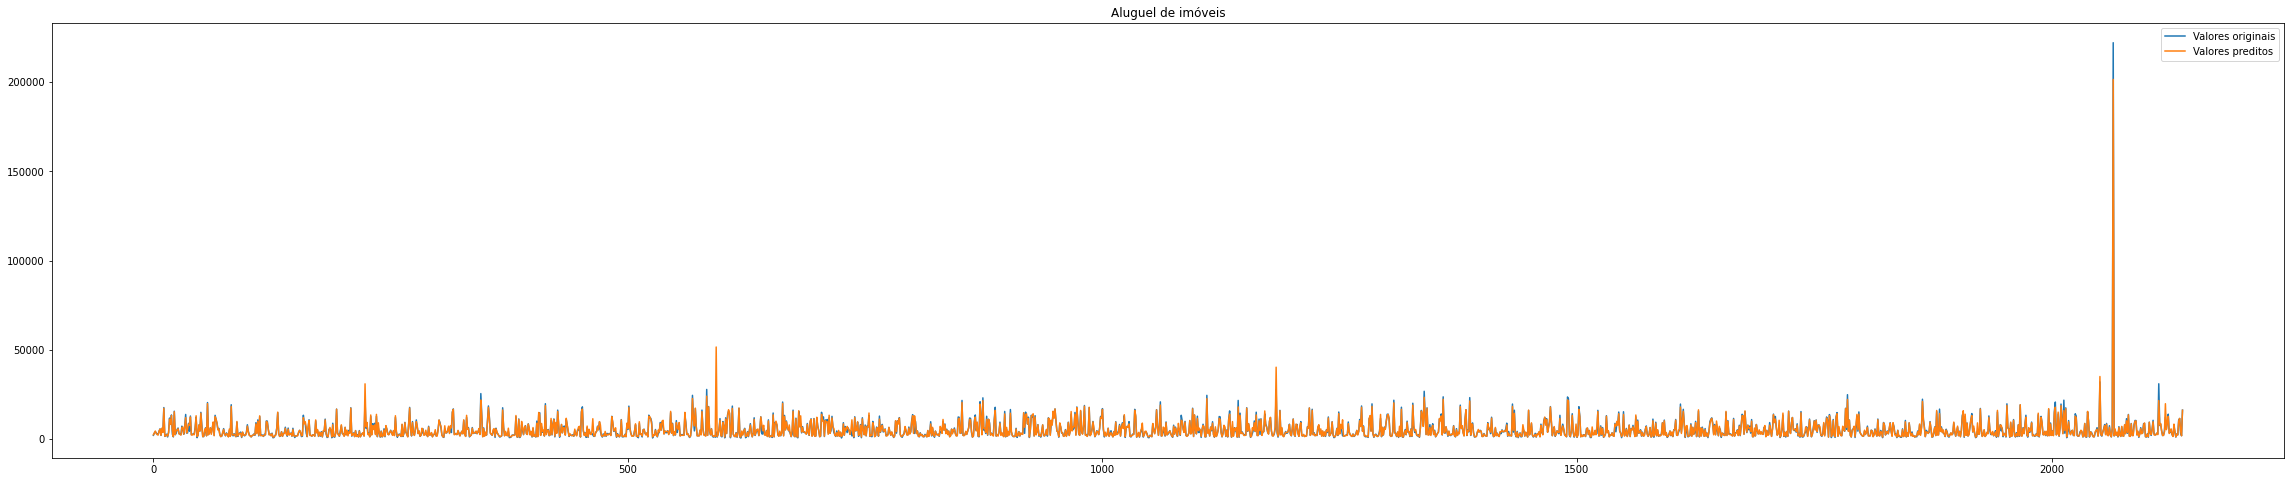

In [16]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores originais")
plt.plot(x_ax, y_pred_test, label="Valores preditos")
plt.title("Aluguel de imóveis")
plt.legend()
plt.show();

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [17]:
tabela = pd.DataFrame()

In [18]:
tabela["valores reais"] = y_test

In [19]:
tabela["valores preditos"] = y_pred_test

In [20]:
tabela["porcentagem de acerto %"]= (y_test/y_pred_test)*100

In [21]:
lista_num = []
for c in tabela["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela["porcentagem de acerto %"]= lista_num

In [22]:
tabela

,valores reais,valores preditos,porcentagem de acerto %
3165,2134,2473.410645,86.277627
9265,3345,3462.752686,96.599449
1940,4226,4515.419922,93.590410
10439,3474,3126.400146,88.881786
395,2760,2511.424805,90.102224
...,...,...,...
5633,10670,10128.360352,94.652247
3951,11550,11585.111328,99.696927
3970,3279,4818.633301,68.048341
2571,1929,1859.332031,96.253065


In [23]:
tabela.to_csv("01-aluguelDeCasas_resultado.csv")

#**Interpretando o modelo globalmente**

In [24]:
df_mg = pd.read_csv("casas_aluguel.csv")

In [25]:
df_mg["floor"].replace("-", np.nan, inplace=True)

In [26]:
#Separando o que é features e target:
X = df_mg.drop(columns="total (R$)")
y = df_mg["total (R$)"]

In [27]:
df_mg

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


**Para a interpretação só podemos considerar features numéricas, vamos transformar as categóricas em numéricas:**

**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [28]:
lista_fc= ["animal", "furniture"]

for i in lista_fc:
  ohe =  OneHotEncoder(handle_unknown='ignore')
  ohe.fit(df_mg[[i]])

  df_mg[i] = ohe.transform(df_mg[[i]]).toarray()

animal
furniture


**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [29]:
lista_oe = ["city", "floor"]

for i in lista_oe:  
  oe =  OrdinalEncoder()
  oe.fit(df_mg[[i]])

  df_mg[i] = oe.transform(df_mg[[i]])

Percebemos que as features que tem dados como números contínuos tem um maior impacto na interpretação do que as features com dados como números discretos e as features com os maiores valores pesam mais na saída final, se analisarmos no dataset veremos que os valores da feature 'rent amount' são maiores que 'hoa' e assim sucessivamente como vemos no gráfico final:

**SHAP**

In [ ]:
!pip install shap
import shap

Vamos tratar os dados nulos dentro da coluna "floor":

In [31]:
ss = SimpleImputer(missing_values=np.nan, strategy="median")
ss.fit(df_mg[["floor"]])

m = ss.transform(df_mg[["floor"]])
df_mg[["floor"]] = m

**O Shap só aceita dados numéricos, vamos transformar as Features categóricas em numéricas.**

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [32]:
ssc = StandardScaler()

ssc.fit(df_mg[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
h= ssc.transform(df_mg[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
df_mg[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']] = h

In [33]:
df_mg

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.752567,-0.147522,-0.432099,-0.878960,-0.383245,1.203018,0.534522,1.761488,0.057145,-0.174935,-0.050103,-0.236589,5618
1,0.752567,0.318035,1.275535,1.253036,-1.012395,-0.543803,0.534522,-0.567702,0.001666,0.312099,0.445121,0.203056,7973
2,-0.649497,-0.128899,-1.285916,-0.878960,-0.383245,1.111080,0.534522,-0.567702,-0.011161,-0.321632,-0.117999,-0.257525,3841
3,-0.649497,-0.182904,-0.432099,-0.878960,-1.012395,-0.635741,0.534522,-0.567702,-0.057981,-0.816881,-0.110920,-0.759976,1421
4,0.752567,-0.231322,-1.285916,-0.878960,-1.012395,-1.647058,-1.870829,-0.567702,-0.075298,-0.908420,-0.109955,-0.885589,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.649497,-0.160557,-0.432099,-0.878960,-0.383245,0.927204,-1.870829,1.761488,-0.049515,-0.709499,-0.110276,-0.655299,1926
10688,0.752567,0.252857,1.275535,1.253036,1.504205,-0.911555,0.534522,-0.567702,0.123527,3.257774,0.195095,2.882798,19260
10689,0.051535,-0.147522,0.421718,0.542371,-1.012395,1.294956,-1.870829,1.761488,-0.012444,0.617228,-0.011167,0.517088,7390
10690,0.051535,-0.054410,-0.432099,-0.168294,0.245905,1.294956,0.534522,1.761488,0.026359,2.377592,-0.028222,2.129120,14020


**Separar em features e target...**

In [34]:
#Separando o que é features e target:
X = df_mg.drop(columns="total (R$)")
y = df_mg["total (R$)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [35]:
xgbr = XGBRegressor().fit(X_train, y_train)

[12:55:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
explainer = shap.TreeExplainer(xgbr)

In [37]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

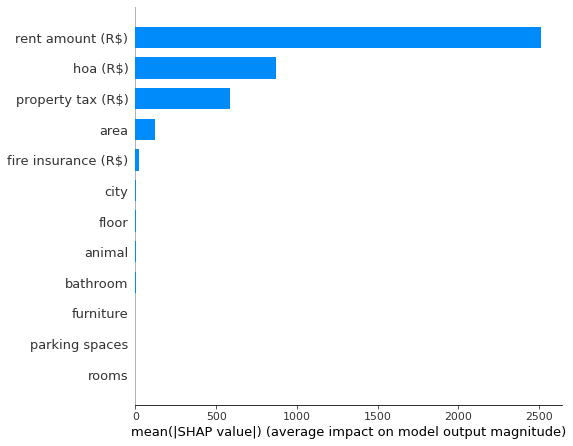

In [38]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")

# **Pré-processamento para a rede neural**

In [ ]:
!pip install scikeras

In [40]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [41]:
df_rn = pd.read_csv("casas_aluguel.csv")

In [42]:
df_rn.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


**Não há dados nulos no dataframe**

In [43]:
df_rn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [44]:
df_rn.isna().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

Vemos que na coluna "floor" não há dados nulos, mas foi preenchido por "-" nos espaços vazios. Vamos transformar em "NaN" para um melhor tratamento na criação dos modelos.

In [45]:
df_rn["floor"].value_counts()

-      2461
1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

In [46]:
df_rn["floor"].replace("-", np.nan, inplace=True)

**Conferindo:**

In [47]:
df_rn["floor"].value_counts()

1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

**Agora vamos tratar o NaN dentro da coluna "floor":**

In [48]:
ss = SimpleImputer(missing_values=np.nan, strategy="median")
ss.fit(df_rn[["floor"]])

m = ss.transform(df_rn[["floor"]])
df_rn[["floor"]] = m

**Separando Features de Target:**

In [49]:
X = df_rn.drop(columns=["total (R$)"])
y = df_rn["total (R$)"]

In [50]:
df_rn.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7.0,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20.0,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6.0,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2.0,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1.0,not acept,not furnished,0,800,25,11,836


**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [51]:
lista_rn_ohe = ["animal", "furniture"]

for i in lista_rn_ohe:
  ohe =  OneHotEncoder(handle_unknown='ignore')
  ohe.fit(df_rn[[i]])

  df_rn[i] = ohe.transform(df_rn[[i]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [52]:
lista_oe = ["city", "floor"]

for i in lista_oe:  
  oe =  OrdinalEncoder()
  oe.fit(df_rn[[i]])

  df_rn[i] = oe.transform(df_rn[[i]])

In [53]:
df_rn.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [54]:
ssc = StandardScaler()

ssc.fit(df_rn[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
h= ssc.transform(df_rn[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
df_rn[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']] = h

In [55]:
df_rn.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [56]:
df_rn.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.752567,-0.147522,-0.432099,-0.878960,-0.383245,0.175502,0.534522,1.761488,0.057145,-0.174935,-0.050103,-0.236589,5618
1,0.752567,0.318035,1.275535,1.253036,-1.012395,2.992689,0.534522,-0.567702,0.001666,0.312099,0.445121,0.203056,7973
2,-0.649497,-0.128899,-1.285916,-0.878960,-0.383245,-0.041205,0.534522,-0.567702,-0.011161,-0.321632,-0.117999,-0.257525,3841
3,-0.649497,-0.182904,-0.432099,-0.878960,-1.012395,-0.908032,0.534522,-0.567702,-0.057981,-0.816881,-0.110920,-0.759976,1421
4,0.752567,-0.231322,-1.285916,-0.878960,-1.012395,-1.124739,-1.870829,-0.567702,-0.075298,-0.908420,-0.109955,-0.885589,836


# **Rede Neural - Keras Regressor**

In [57]:
df_rn

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.752567,-0.147522,-0.432099,-0.878960,-0.383245,0.175502,0.534522,1.761488,0.057145,-0.174935,-0.050103,-0.236589,5618
1,0.752567,0.318035,1.275535,1.253036,-1.012395,2.992689,0.534522,-0.567702,0.001666,0.312099,0.445121,0.203056,7973
2,-0.649497,-0.128899,-1.285916,-0.878960,-0.383245,-0.041205,0.534522,-0.567702,-0.011161,-0.321632,-0.117999,-0.257525,3841
3,-0.649497,-0.182904,-0.432099,-0.878960,-1.012395,-0.908032,0.534522,-0.567702,-0.057981,-0.816881,-0.110920,-0.759976,1421
4,0.752567,-0.231322,-1.285916,-0.878960,-1.012395,-1.124739,-1.870829,-0.567702,-0.075298,-0.908420,-0.109955,-0.885589,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.649497,-0.160557,-0.432099,-0.878960,-0.383245,-0.257912,-1.870829,1.761488,-0.049515,-0.709499,-0.110276,-0.655299,1926
10688,0.752567,0.252857,1.275535,1.253036,1.504205,2.342569,0.534522,-0.567702,0.123527,3.257774,0.195095,2.882798,19260
10689,0.051535,-0.147522,0.421718,0.542371,-1.012395,0.392208,-1.870829,1.761488,-0.012444,0.617228,-0.011167,0.517088,7390
10690,0.051535,-0.054410,-0.432099,-0.168294,0.245905,0.392208,0.534522,1.761488,0.026359,2.377592,-0.028222,2.129120,14020


In [ ]:
X = df_rn.drop(columns=["total (R$)"])
y = df_rn["total (R$)"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [20],
          "kr__epochs":[1000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

In [59]:
grid_kr.best_params_

{'kr__batch_size': 20, 'kr__epochs': 1000, 'kr__optimizer': 'adam'}

In [60]:
grid_kr.best_score_

-885.2583568075004

In [61]:
y_pred = grid_kr.predict(X_test)

107/107 [==============================] - 0s 2ms/step


In [62]:
y_pred

array([3422.8394, 2464.414 , 2718.628 , ..., 1520.4844, 3505.296 ,
       1356.9244], dtype=float32)

In [63]:
tabela = pd.DataFrame()

In [64]:
tabela["Valor real"] = y_test

In [65]:
tabela["Valor preditivo"] = y_pred

In [66]:
tabela = tabela.sort_index()
tabela = tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo
0,0,5618,5141.781250
1,3,1421,1374.907593
2,8,16440,14856.061523
3,10,2747,2558.366699
4,14,5343,4906.450684
...,...,...,...
2134,10665,1897,1791.612427
2135,10681,16040,14486.405273
2136,10682,4419,4063.904785
2137,10685,8726,7940.302246


In [67]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 91.63%


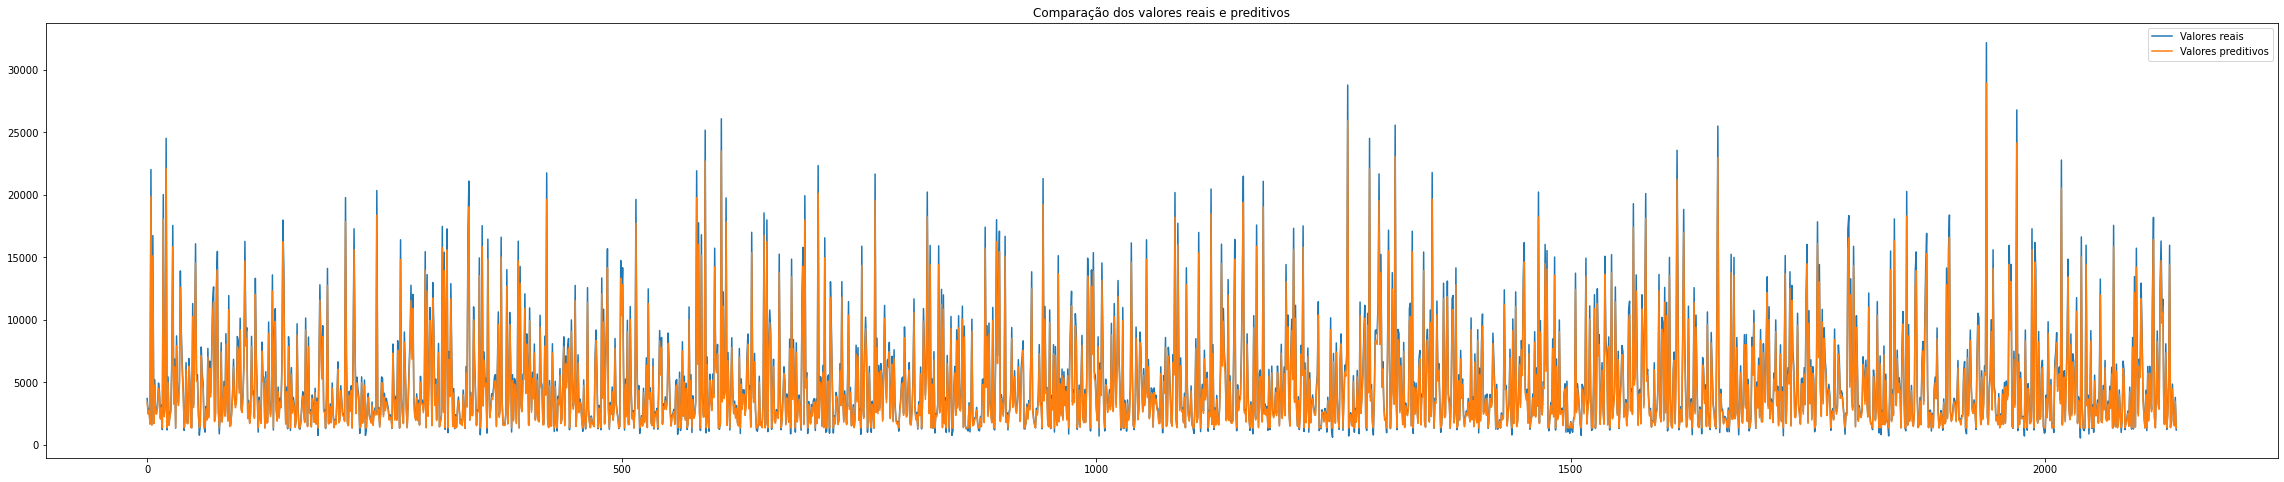

In [68]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();

In [69]:
import pickle

In [70]:
with open("grid_kr.pkl", "wb") as f:
    pickle.dump(grid_kr, f)

In [71]:
with open("grid_kr.pkl", "rb") as f:
    
    grid_kr = pickle.load(f)

# **No XGBoost a acurácia deu maior do que no Keras. XGBoost: 95%, Keras: 91%**